In [1]:
from __future__ import print_function, division
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from Attributions import *

In [2]:
l1Lambda = 0
l2Lambda = 1
record_freq = 25
batch_size = 64
img_means = torch.Tensor([0.485, 0.456, 0.406])
img_stds = torch.tensor([0.229, 0.224, 0.225])
resnet = torchvision.models.resnet18(pretrained=True, progress=True).cuda()
for param in resnet.parameters():
    param.requires_grad= False

In [3]:
resnet.fc = nn.Linear(in_features = 512, out_features = 5, bias = True).cuda()

In [4]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(img_means, img_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(img_means, img_stds)
    ]),
}

data_dir = 'data/Linnaeus 5 256X256'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4, pin_memory = True)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([3, 1810, 1810])


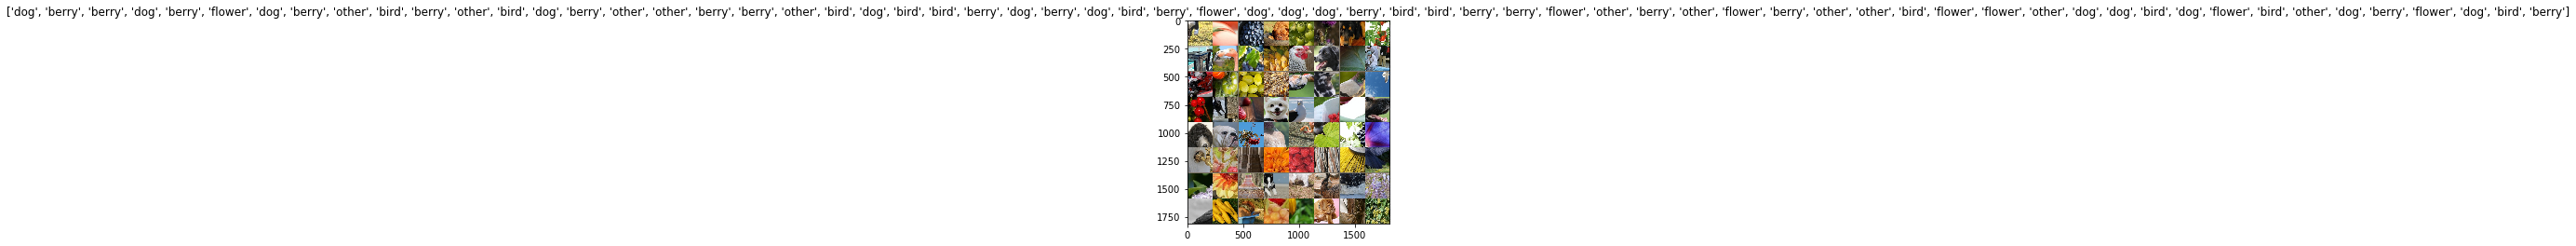

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, optimizer, num_epochs = 25):
    for epoch in range(num_epochs):
        for phase in ['train', 'test']:
            running_loss = 0.0
            running_correct = 0.0
            running_total = 0.0
            if phase == 'train':
                model.train()
            elif phase == 'test':
                model.eval()
            batches = iter(dataloaders[phase])
            for images, labels in batches:
                batch_size = len(labels)
                cudaIm = images.cuda()
                output = model(cudaIm)
                _, pred = torch.max(output, 1)
                model.zero_grad()
                one_hot = torch.zeros(batch_size,5).cuda()
                for i in range(batch_size):
                    one_hot[i][labels[i]] = 1
                loss = nn.functional.mse_loss(output, one_hot)
                l1_loss = 0
                l2_loss = 0
                for weight in resnet.fc.weight:
                    l1_loss += torch.sum(torch.abs(weight)).item() * l1Lambda #add l1 regularization term (Lasso)
                    l2_loss += torch.sum(weight*weight).item() * l2Lambda #add L2 regularization term (Ridge)
                loss += l1_loss + l2_loss
                running_total += batch_size
                running_loss += loss
                running_correct += torch.sum(pred == labels.data.cuda()).item()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    if running_total%record_freq == 0:
                        train_losses.append(loss/batch_size)
                        train_acc.append(running_correct/running_total)
                elif phase == 'test':
                    if running_total%record_freq == 0:
                        val_losses.append(loss/batch_size)
                        val_acc.append(running_correct/running_total)
                
                
            print("epoch: {} mode: {} avg loss: {} accuracy: {}".format(epoch, phase, 
                                                                      running_loss/running_total, 
                                                                      running_correct/running_total))
            

In [8]:
adam = optim.Adam(resnet.fc.parameters())#only train parameters of linear regression layer
train_model(resnet, adam, 2)

epoch: 0 mode: train avg loss: 0.02306964062154293 accuracy: 0.7351666666666666
epoch: 0 mode: test avg loss: 0.01847706362605095 accuracy: 0.8995
epoch: 1 mode: train avg loss: 0.015842275694012642 accuracy: 0.8835
epoch: 1 mode: test avg loss: 0.014238281175494194 accuracy: 0.9485


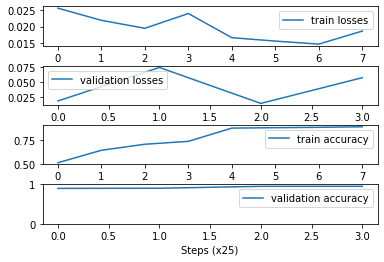

In [9]:
plt.subplots_adjust(hspace = 0.5)
plt.subplot(4, 1, 1)
plt.plot(range(len(train_losses)), train_losses, label = "train losses")
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(range(len(val_losses)), val_losses, label = "validation losses")
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(range(len(train_acc)), train_acc, label = "train accuracy")
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(range(len(val_acc)), val_acc, label = "validation accuracy")
plt.legend()
plt.xlabel("Steps (x25)")
plt.ylim(0, 1)
plt.show()

In [10]:
batches = iter(dataloaders['test'])
images, labels = next(batches)
image = images[0]
label = labels[0]
att = random_baseline_attribution(resnet, image.cuda(), 50, img_means, img_stds, lambda x: F.softmax(x, dim = 1))

D:\Stuff\pytorch_projects\Attributions\IntegratedGradients.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generate_noise = lambda : noise_like(img.cuda(), torch.tensor(means).cuda(), torch.tensor(stds).cuda())


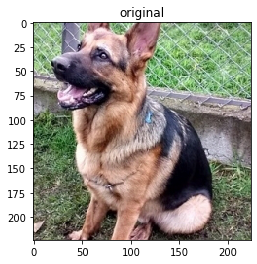

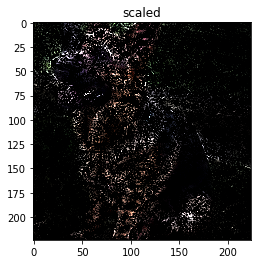

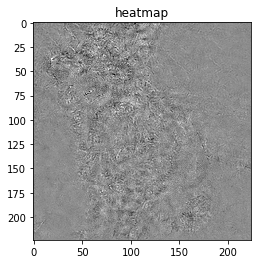

In [11]:
att_sum = att.sum(axis = 1)[0] #sum along color axis
simple_scale(att_sum, 1, 70)
imshow(image, "original")
attShape = att_sum.shape
att_imshow(image, att_sum.cpu(), "scaled")
heatmap_imshow(att_sum.cpu(), "heatmap")
